# Insights about "No Show" to Medical Appointments

A person makes a doctor appointment but does not show up. The following notebook contains analysis of the dataset to understand the correlation between patient not showing up and various datapoints.

Data set is available on kaggle - https://www.kaggle.com/joniarroba/noshowappointments

## Table of Contents
<ul>
<li><a href="#1">Importing and Exploring Data</a></li>
<li><a href="#2">Data Wrangling</a></li>
<li><a href="#3">Exploratory Data Analysis</a></li>
<li><a href="#4">Conclusion</a></li>
</ul>

<a id='1'></a>
## Step 1 - Importing and Exploring Data

In [43]:
#importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

% matplotlib inline

In [2]:
#reading and loading files

df = pd.read_csv("KaggleV2-May-2016.csv")
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [3]:
#checking column names and df shape

print(df.columns)
print(df.shape[0])
print(df.shape[1])

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')
110527
14


### Observations - 

- Initial database consists of 110,527 rows
- 14 columns

### Issues -

- Can see typos in come column names - Hipertension, Handcap
- Convert to CamelCase - SMS_received, No-show

In [4]:
# checking number of unique patients
print(df.PatientId.nunique(), 
      round(df.PatientId.nunique()/df.shape[0]*100), 
      round(df.AppointmentID.nunique()/df.PatientId.nunique()))

df_summary = df.groupby(['PatientId'])['AppointmentID'].count().sort_values(ascending = False)
round(df_summary[df_summary>2].count()/df.PatientId.nunique()*100)

62299 56 2


17.0

### Observations - 

- 56 percent of patients are unique
- Average appointments per patient is 2 approx
- Some patients are very regular. 17% patients have appointments greater than the average appointment

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Observations - 

- Mean age 37
- 9% have scholarships
- 19% have hypertension
- 7% have diabeties
- 3% have Alcoholism
- 32% received SMS

In [6]:
# checking other columns
print(sorted(df.Age.unique()))
print(sorted(df.Handcap.unique()))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
[0, 1, 2, 3, 4]


In [7]:
print(df.isnull().sum().sum())
df.duplicated().sum()

0


0

### Observations

- Remove errors and outliers in Age
- In data set instructions they have mentioned that 2,3,4 refer to the number of disabilities (Not an error)
- zero null and duplicated values

In [8]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

<a id='2'></a>
## Step 2 - Data Wrangling

We can observe that following corrections are required to the dataframe.

- renaming column (discussed above in detail)
- assigning appropriate datatypes to columns 
    - PatientId to int
    - ScheduledDay, AppointmentDay to datetime
    - Change 2, 3, 4 values in handicap to 1
    - Change NoShow to 0 and 1 and astype int
    - Remove oulier and error from age

In [9]:
df.PatientId = df.PatientId.astype(int)

In [10]:
#removing typos from columns
df.rename(columns={'Hipertension' : 'Hypertension',
                   'Handcap' : 'Handicap',
                   'SMS_received' : 'SmsReceived',
                   'No-show' : 'NoShow'}, inplace = True)

In [11]:
df['NoShow'] = df['NoShow'].replace(['No'], 0)
df['NoShow'] = df['NoShow'].replace(['Yes'], 1)
df['NoShow'] = df['NoShow'].astype(int)

In [12]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [13]:
df.dtypes

PatientId                       int64
AppointmentID                   int64
Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hypertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handicap                        int64
SmsReceived                     int64
NoShow                          int64
dtype: object

In [14]:
df['Handicap'] = df['Handicap'].replace([2], 1)
df['Handicap'] = df['Handicap'].replace([3], 1)
df['Handicap'] = df['Handicap'].replace([4], 1)

In [15]:
df['Handicap'].unique()

array([0, 1])

### Convert date column to discrete variables

- ScheduledDay can be converted to day of week, hour of day
- AppointmentDay can be converted to day of week
- WaitTime = ScheduledDay - AppointmentDay
- Time delta (WaitTime) can be converted to hours value

Since we have dates in correct format now, let's start with exploring those columns first.

In [16]:
print(df.ScheduledDay.describe())
df.AppointmentDay.describe()

count                        110527
unique                       103549
top       2016-05-06 07:09:54+00:00
freq                             24
first     2015-11-10 07:13:56+00:00
last      2016-06-08 20:07:23+00:00
Name: ScheduledDay, dtype: object


count                        110527
unique                           27
top       2016-06-06 00:00:00+00:00
freq                           4692
first     2016-04-29 00:00:00+00:00
last      2016-06-08 00:00:00+00:00
Name: AppointmentDay, dtype: object

### Observations

- ScheduledDay dates start from 2015-11-10 and end on 2016-06-08
- AppointmentDay dates start from 2016-04-29 and end on 2016-06-08 

There seems to be an error in this dataframe. It contains ScheduledDay dates even before AppointmentDay dates.
You cannot book appointment in the past.

In [17]:
#removing error entries from data
df[df['AppointmentDay'] > df['ScheduledDay']].count()['PatientId']

# 71959 contains ScheduledDay dates even before AppointmentDay dates. You cannot book appointment in the past.
# cleaning dataframe by removing these rows

df = df[df['AppointmentDay'] <= df['ScheduledDay']]
df.shape

(38568, 14)

In [18]:
df['AppointmentDow'] = df['AppointmentDay'].dt.dayofweek
df['ScheduledDow'] = df['ScheduledDay'].dt.dayofweek
df['ScheduledHod'] = df['ScheduledDay'].dt.hour
df['WaitTime'] = df['ScheduledDay'] - df['AppointmentDay']

In [19]:
#removing outliers from age 
df = df[(df['Age'] >= 1) & (df['Age'] <= 100)]

In [20]:
print(df.shape)
df.head(2)

(37157, 18)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,AppointmentDow,ScheduledDow,ScheduledHod,WaitTime
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,4,4,18,18:38:08
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,4,4,16,16:08:27


### Notes -

- completed data wrangling
- explore Neighbourhood feature now below

In [21]:
#print(df.Neighbourhood.nunique())
#print(df.Neighbourhood.unique())
print(df.Neighbourhood.value_counts())

JARDIM CAMBURI       2457
MARIA ORTIZ          1984
RESISTÊNCIA          1546
SANTA MARTHA         1437
JARDIM DA PENHA      1212
                     ... 
MORADA DE CAMBURI      18
ILHA DO BOI            12
AEROPORTO               3
ILHA DO FRADE           2
PARQUE INDUSTRIAL       1
Name: Neighbourhood, Length: 80, dtype: int64


### Observations -

- Neighbourhood has 80 unique values
- JARDIM CAMBURI occurs 2457 times in df

<a id='3'></a>
## Step 3 - Analysing and Vizualizing Data

In [22]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,AppointmentDow,ScheduledDow,ScheduledHod,WaitTime
count,3.715700e+04,3.715700e+04,37157.000000,37157.000000,37157.000000,37157.000000,37157.000000,37157.000000,37157.0,37157.00000,37157.000000,37157.000000,37157.000000,37157
mean,1.511894e+14,5.713163e+06,35.753694,0.112092,0.182173,0.069058,0.041392,0.025083,0.0,0.04699,1.835993,1.836074,10.231423,0 days 10:43:12.679118
std,2.601172e+14,4.419351e+04,22.644121,0.315484,0.385992,0.253557,0.199198,0.156379,0.0,0.21162,1.371045,1.371006,3.032430,0 days 03:08:35.774852
min,4.374100e+04,5.637406e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,6.000000,0 days 06:09:36
25%,4.351389e+12,5.674926e+06,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,1.000000,1.000000,8.000000,0 days 08:07:36
50%,3.315546e+13,5.710934e+06,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,2.000000,2.000000,9.000000,0 days 09:46:53
75%,9.522815e+13,5.752163e+06,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,3.000000,3.000000,13.000000,0 days 13:17:19
max,9.999816e+14,5.790484e+06,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,5.000000,5.000000,20.000000,6 days 13:49:20


In [23]:
# checking number of unique patients
print(df.PatientId.nunique(), 
      round(df.PatientId.nunique()/df.shape[0]*100), 
      round(df.AppointmentID.nunique()/df.PatientId.nunique()))

df_summary = df.groupby(['PatientId'])['AppointmentID'].count().sort_values(ascending = False)
round(df_summary[df_summary>2].count()/df.PatientId.nunique()*100)

26265 71 1


7.0

### Clean vs Original Data set

#### Original observations
- 56 percent of patients are unique
- Average appointments per patient is 2 approx
- Some patients are very regular. 17% patients have appointments greater than the average appointment
- Mean age 37
- 9% have scholarships
- 19% have hypertension
- 7% have diabeties
- 3% have Alcoholism
- 32% received SMS

#### Observations on clean data set 
- 71 percent of patients are unique
- Average appointments per patient is 2 approx
- Some patients are regular. 7% patients have appointments greater than the average appointment
- 0% received SMS
- No major changes in other variables

In [24]:
# wait time hours impact on show or no show
# note - 0 is show and 1 is no show
# no show rate is -> sum/allcount
# mean of bool is sum divided by total *100 is the rate use groupby and mean
# basic no show rate
#print(round(df.NoShow.sum()/df.shape[0]*100))

round(df.NoShow.mean()*100)

5

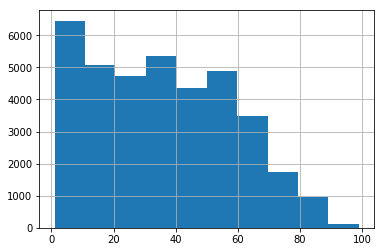

In [25]:
# age brackets
'''
1-20
21-40
41-60
61-80
81-100
'''
df.Age.hist()

In [26]:
#creating a new column of age groups 

def age_brackets(x):
    if ((x >= 1) & (x <= 20)):
        y = "1-20"
    elif ((x >= 21) & (x <= 40)):
        y = "21-40"
    elif ((x >= 41) & (x <= 60)):
        y = "41-60"
    elif ((x >= 61) & (x <= 80)):
        y = "61-80"
    elif ((x >= 81) & (x <= 100)):
        y = "81-100"
    return y
        
df['AgeBracket'] = df.Age.apply(age_brackets)
df['AgeBracket']

0         61-80
1         41-60
2         61-80
3          1-20
4         41-60
          ...  
110511     1-20
110512    41-60
110513     1-20
110514    41-60
110517     1-20
Name: AgeBracket, Length: 37157, dtype: object

In [27]:
# issue - appointmentid is not properly camelcased
df.rename(columns = {'AppointmentID': 'AppointmentId'}, inplace = True)

In [28]:
#creating a new column of patient type based on number of appointments

patient_appointments = df.PatientId.value_counts()
print(patient_appointments)

def patient_type(x):
    z = patient_appointments
    if ((z[x] >= 2) & (z[x] <= 10)):
        r = "2-10"
    elif ((z[x] >= 11) & (z[x] <= 30)):
        r = "11-30"
    elif ((z[x] >= 31) & (z[x] <= 50)):
        r = "31-50"
    elif ((z[x] >= 51) & (z[x] <= 70)):
        r = "51-70"
    elif ((z[x] >= 71) & (z[x] <= 90)):
        r = "71-90"
    elif ((z[x] >= 0) & (z[x] <= 1)):
        r = "0-1"
    return r

99637671331        81
822145925426128    80
26886125921145     68
33534783483176     65
258424392677       61
                   ..
33319242582744      1
526546936398477     1
781164975242555     1
85852445534473      1
57863365759569      1
Name: PatientId, Length: 26265, dtype: int64


In [29]:
df['PatientType'] = df.PatientId.apply(patient_type)

In [30]:
def dataframe_viz_no_show_rate(df_viz, x, y = (8, 6), z = 0):
    no_show_rate = round(df_viz['NoShow'].sum()/df_viz['NoShow'].count()*100)
    plt.figure(figsize=y)
    plt.bar(no_show_rate.index, no_show_rate.values)
    plt.title("No Show Rate"+" vs "+x)
    plt.xlabel(x)
    plt.ylabel("No Show Rate")
    if z == 1:
        plt.xticks([0,1])

In [31]:
df.columns

Index(['PatientId', 'AppointmentId', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SmsReceived', 'NoShow',
       'AppointmentDow', 'ScheduledDow', 'ScheduledHod', 'WaitTime',
       'AgeBracket', 'PatientType'],
      dtype='object')

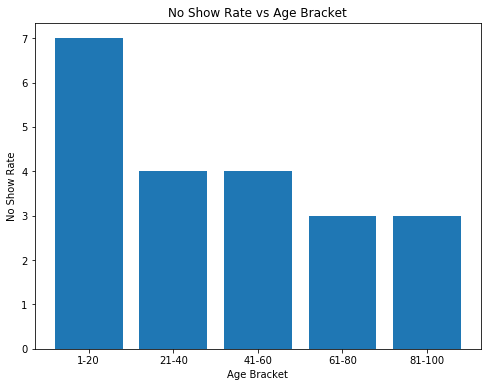

In [32]:
dataframe_viz_no_show_rate(df.groupby('AgeBracket'), "Age Bracket")

In [94]:
df.groupby(['AgeBracket', 'Gender'])[['Scholarship', 'Hypertension',
                          'Diabetes', 'Alcoholism', 'Handicap','NoShow']].mean()*100

Scholarship  Hypertension   Diabetes  Alcoholism  Handicap  \
AgeBracket Gender                                                               
1-20       F         14.116291      0.131774   0.214133    0.082359  1.334212   
           M         11.420715      0.164986   0.164986    0.238313  1.668194   
21-40      F         20.773577      6.518905   2.028104    2.448211  1.419673   
           M          1.988636      5.239899   1.167929    4.324495  2.967172   
41-60      F         13.338684     31.364366  10.850722    4.606742  2.182986   
           M          4.304539     25.036603   8.111274   17.013177  3.572474   
61-80      F          5.095150     59.023941  26.856967    1.350522  4.143646   
           M          2.367206     48.094688  19.630485   17.263279  5.080831   
81-100     F          0.320513     64.102564  24.519231    0.160256  9.134615   
           M          0.332226     56.810631  15.282392    0.664452  9.966777   

                     NoShow  
AgeBracket Gender            
1-20       F       5.056828  
           M       9.734189  
21-40      F       3.694046  
           M       4.292929  
41-60      F       3.467095  
           M       3.748170  
61-80      F       3.038674  
           M       2.829099  
81-100     F       2.884615  
           M       2.325581

### Observation
It can be observed that "No Show Rate" is maximum in 1-20 age group. This may be because this age group is least effected by diseases like hypertension, diabetes, alcoholism. 

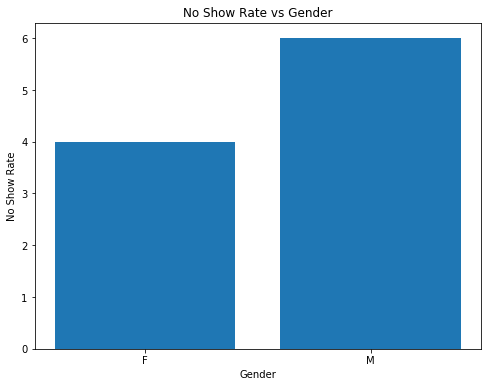

In [85]:
dataframe_viz_no_show_rate(df.groupby('Gender'), "Gender")

In [86]:
df.groupby('Gender')['Age'].mean()

Gender
F    37.483237
M    32.916069
Name: Age, dtype: float64

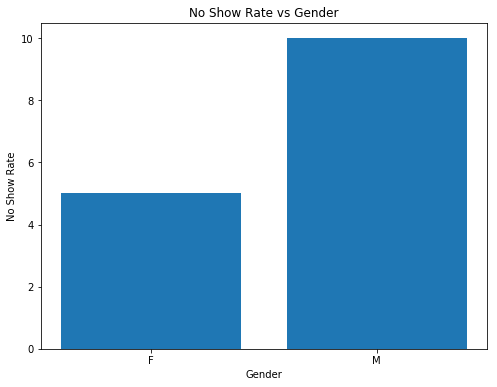

In [92]:
dataframe_viz_no_show_rate(df.query('AgeBracket == "1-20"').groupby('Gender'), "Gender")

## Observation

It can be observed that younger males have higher "No show rate".

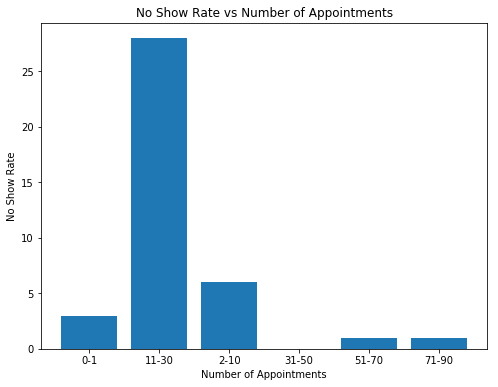

In [42]:
dataframe_viz_no_show_rate(df.groupby('PatientType'), "Number of Appointments")

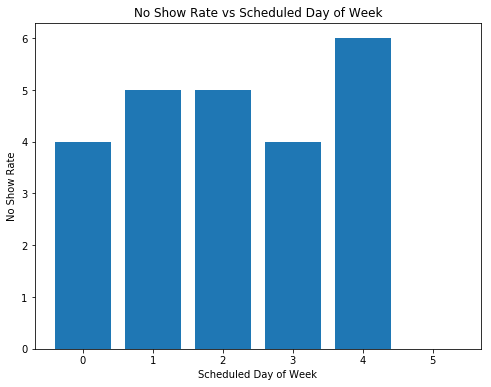

In [35]:
dataframe_viz_no_show_rate(df.groupby('ScheduledDow'), 
                           "Scheduled Day of Week")

### Observation

It can be observed that maximum "No Show Rate" is on Fridays. 
This may be because the weekend is close and people prioritise other plans over their medical appointment.

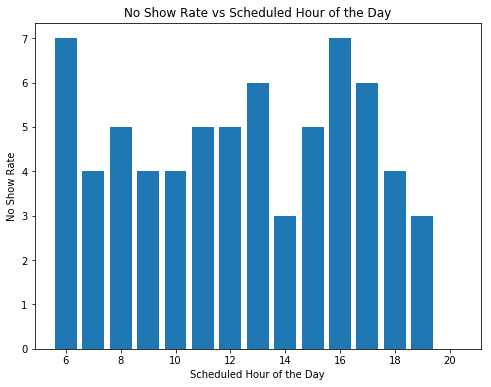

In [36]:
dataframe_viz_no_show_rate(df.groupby('ScheduledHod'), 
                           "Scheduled Hour of the Day")

In [37]:
#error in wait time hours
def convert_to_hours(x):
    days, seconds = x.days, x.seconds
    hours = days * 24 + seconds // 3600
    return hours

df['WaitTimeHours'] = df['WaitTime'].apply(convert_to_hours)
df['WaitTimeHours'].max()

157

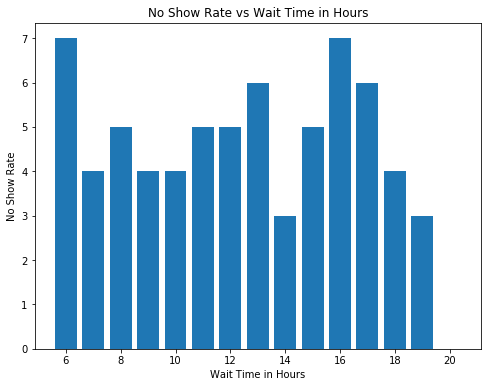

In [38]:
dataframe_viz_no_show_rate(df.query('WaitTimeHours <= 24').groupby('WaitTimeHours'), 
                          "Wait Time in Hours")

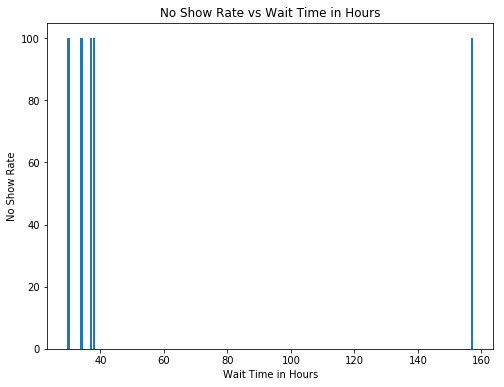

In [39]:
dataframe_viz_no_show_rate(df.query('WaitTimeHours > 24').groupby('WaitTimeHours'),
                           "Wait Time in Hours")

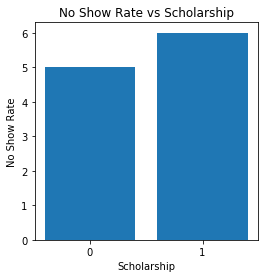

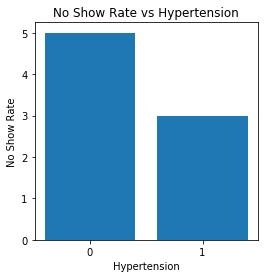

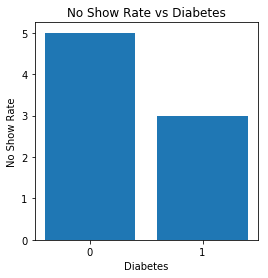

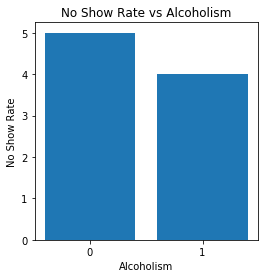

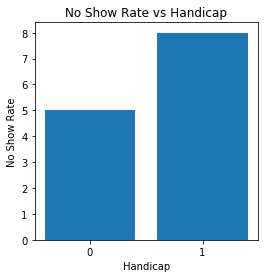

In [40]:
dataframe_viz_no_show_rate(df.groupby('Scholarship'), "Scholarship", (4,4), 1)
dataframe_viz_no_show_rate(df.groupby('Hypertension'), "Hypertension", (4,4), 1)
dataframe_viz_no_show_rate(df.groupby('Diabetes'), "Diabetes", (4,4), 1)
dataframe_viz_no_show_rate(df.groupby('Alcoholism'), "Alcoholism", (4,4), 1)
dataframe_viz_no_show_rate(df.groupby('Handicap'), "Handicap", (4,4), 1)

In [121]:
print(df[df['AgeBracket'] == "1-20"].groupby('Scholarship')['NoShow'].mean()*100)
df[df['AgeBracket'] != "1-20"].groupby('Scholarship')['NoShow'].mean()*100

Scholarship
0    7.007764
1    9.054054
Name: NoShow, dtype: float64


Scholarship
0    3.473372
1    4.134078
Name: NoShow, dtype: float64

### Observation

- People who have diseases like hypertension, diabetes, alcoholism are more likely to show up to their appointment.
- Handicap persons have higher "No show rate" than others. They may be facing some difficulties to commute to the meeting place.
- The No Show Rate for scholarship may be skewed by young people who have scholarship but are not showing up due to other reasons.

Text(0,0.5,'Neighbourhoods')

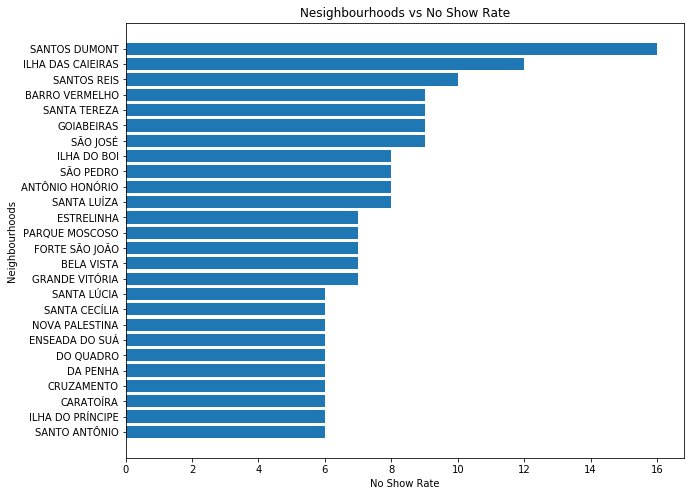

In [113]:
base_noshow = round(df['NoShow'].mean()*100)
dfn = round(df.groupby('Neighbourhood')['NoShow'].mean()*100)
dfn = dfn[dfn > base_noshow]
#no_show_rate = dfn
no_show_rate = no_show_rate.sort_values(ascending = True)
#no_show_rate = no_show_rate.tail(40)
plt.figure(figsize=(10, 8))
plt.barh(no_show_rate.index, no_show_rate.values)
plt.title("Nesighbourhoods vs No Show Rate")
plt.xlabel("No Show Rate")
plt.ylabel("Neighbourhoods")

### Observation

The figure above shows the "No Show Rate" of neighbourhoods with higher than average values.

<a id='4'></a>
## Step 4 - Conclusion

1. It can be observed that "No Show Rate" is maximum in 1-20 age group. This may be because this age group is least effected by diseases like hypertension, diabetes, alcoholism.

2. It can be observed that younger males have higher "No show rate".

3. It can be observed that maximum "No Show Rate" is on Fridays. This may be because the weekend is close and people prioritise other plans over their medical appointment.

4. People who have diseases like hypertension, diabetes, alcoholism are more likely to show up to their appointment.

5. Handicap persons have higher "No show rate" than others. They may be facing some difficulties to commute to the meeting place.

6. The No Show Rate for schoarships may be skewed by young people having scholarship but not showing up due to other reasons.

6. The figure above shows the "No Show Rate" of neighbourhoods with higher than average values.